In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import json

In [19]:
import random

# === Фиксируем SEED для повторяемости результатов ===
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === Для DataLoader с num_workers > 0 ===
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [20]:
DATA_PATH = 'dataset/maria.csv'
BASE_MODEL_PATH = 'password_lstm.pth'
PERSONAL_MODEL_PATH = 'personal_lstm.pth'
PATTERN_OUTPUT_PATH = 'personal_password_patterns.json'

In [21]:
# === Параметры ===
max_sequence_length = 50
embedding_dim = 64
hidden_dim = 128
batch_size = 64
num_epochs = 10

In [22]:
# === Определяем архитектуру LSTM ===
class PasswordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PasswordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [23]:
# === Функция для сохранения модели ===
def save_model(model, optimizer, epoch, file_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"✅ Модель сохранена в '{file_path}'")

In [24]:
# === Функция для загрузки модели ===
def load_model(model, optimizer, file_path):
    if os.path.exists(file_path):
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"✅ Модель загружена из '{file_path}' — продолжаем с эпохи {start_epoch + 1}")
        return start_epoch
    else:
        print("⚠️ Файл с моделью не найден — начинаем обучение с нуля.")
        return 0

In [25]:
# === Подготовка токенизации ===
base_chars = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&*()-_=+[]{}|;:,.<>?/\\')
char_to_idx = {char: idx + 1 for idx, char in enumerate(base_chars)}
char_to_idx['<PAD>'] = 0
char_to_idx['<UNK>'] = len(char_to_idx) + 1
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


In [26]:
# === Подготовка данных ===
def prepare_data(passwords, char_to_idx):
    sequences = [[char_to_idx.get(char, char_to_idx['<UNK>']) for char in password] for password in passwords]
    sequences = [seq[:max_sequence_length] + [0] * (max_sequence_length - len(seq)) for seq in sequences]

    X = torch.tensor(sequences, dtype=torch.long)
    y = torch.tensor([seq[1:] + [0] for seq in sequences], dtype=torch.long)

    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [27]:
# === Инициализация базовой модели ===
vocab_size = len(char_to_idx)
base_model = PasswordLSTM(vocab_size, embedding_dim, hidden_dim)
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001)

In [28]:
# === Попробуем загрузить базовую модель ===
start_epoch = load_model(base_model, base_optimizer, BASE_MODEL_PATH)

⚠️ Файл с моделью не найден — начинаем обучение с нуля.


In [29]:
# === Загружаем личные пароли ===
if os.path.exists(DATA_PATH):
    personal_data = pd.read_csv(DATA_PATH)['String'].tolist()
    personal_loader = prepare_data(personal_data, char_to_idx)
else:
    raise FileNotFoundError("⚠️ Файл 'maria.csv' не найден!")

In [30]:
# === Создание новой модели для личных паролей ===
personal_model = PasswordLSTM(vocab_size, embedding_dim, hidden_dim)
personal_optimizer = optim.Adam(personal_model.parameters(), lr=0.001)


In [31]:
# === Синхронизируем веса новой модели с базовой ===
personal_model.load_state_dict(base_model.state_dict())

<All keys matched successfully>

Epoch 1/10, Loss: 4.5629
Epoch 2/10, Loss: 4.4302
Epoch 3/10, Loss: 4.2817
Epoch 4/10, Loss: 4.0968
Epoch 5/10, Loss: 3.8576
Epoch 6/10, Loss: 3.5517
Epoch 7/10, Loss: 3.1800
Epoch 8/10, Loss: 2.7686
Epoch 9/10, Loss: 2.3670
Epoch 10/10, Loss: 2.0147


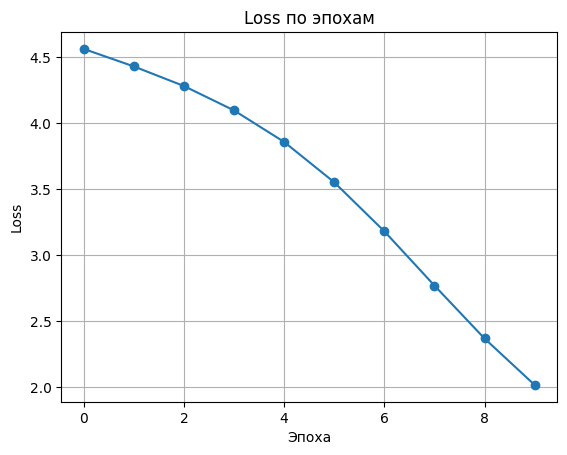

In [32]:
# === Обучение личной модели с логом потерь ===


def train_model(model, dataloader, optimizer, loss_fn, num_epochs):
    """
    Обучает модель на заданных данных и возвращает список потерь по эпохам.
    
    Args:
        model (nn.Module): модель PyTorch
        dataloader (DataLoader): обучающая выборка
        optimizer (torch.optim.Optimizer): оптимизатор
        loss_fn (nn.Module): функция потерь
        num_epochs (int): количество эпох
    
    Returns:
        list: список значений потерь по эпохам
    """
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output.view(-1, model.fc.out_features), batch_y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return loss_history

loss_fn = nn.CrossEntropyLoss()
loss_history = train_model(personal_model, personal_loader, personal_optimizer, loss_fn, num_epochs)

# === Визуализация ===
import matplotlib.pyplot as plt

plt.plot(loss_history, marker='o')
plt.title('Loss по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [34]:
# === Сохранение личной модели ===
save_model(personal_model, personal_optimizer, num_epochs - 1, PERSONAL_MODEL_PATH)


✅ Модель сохранена в 'personal_lstm.pth'


In [35]:
# === Анализ структуры пароля ===
import re
from typing import List, Dict

def analyze_passwords(passwords: List[str]) -> Dict:
    """
    Анализирует список паролей и возвращает структуру повторяющихся шаблонов:
    - Цифры
    - Часто встречающиеся подстроки
    - Мутации
    - Zigzag-регистр
    - Маски
    - Профиль использования

    Returns:
        dict: словарь с анализом структуры паролей
    """
    numbers = {}
    words = {}
    mutations = {}
    masks = {}
    mutation_map = {'0': 'o', '1': 'i', '@': 'a', '$': 's', '3': 'e', '5': 's', '7': 't'}

    mutation_count = 0
    zigzag_count = 0
    number_count = 0
    word_count = 0

    def extract_mask(pwd):
        return ''.join([
            'X' if c.isalpha() else
            'D' if c.isdigit() else
            'S' if re.match(r'[!@#$%^&*()\-_=+]', c) else '_'
            for c in pwd
        ])

    for pwd in passwords:
        # --- маски ---
        m = extract_mask(pwd)
        masks[m] = masks.get(m, 0) + 1

        # --- цифры ---
        digits = ''.join(filter(str.isdigit, pwd))
        if digits:
            number_count += 1
            for d in set(digits):
                numbers[d] = numbers.get(d, 0) + 1

        # --- слова (3–7 символов) ---
        local_word_found = False
        for length in range(3, 8):
            for i in range(len(pwd) - length + 1):
                substr = pwd[i:i + length]
                words[substr] = words.get(substr, 0) + 1
                local_word_found = True
        if local_word_found:
            word_count += 1

        # --- мутации ---
        mutated = ''.join([mutation_map.get(c, c) for c in pwd])
        if mutated != pwd:
            mutation_count += 1
            mutations[mutated] = mutations.get(mutated, 0) + 1

        # --- zigzag ---
        if any(c.isupper() for c in pwd) and any(c.islower() for c in pwd):
            zigzag_count += 1

    total = len(passwords)
    profile = {
        "mutation_usage": f"{(mutation_count / total) * 100:.2f}%",
        "zigzag_usage": f"{(zigzag_count / total) * 100:.2f}%",
        "number_usage": f"{(number_count / total) * 100:.2f}%",
        "word_usage": f"{(word_count / total) * 100:.2f}%"
    }

    return {
        "numbers": numbers,
        "words": words,
        "mutations": mutations,
        "masks": masks,
        "profile": profile
    }


In [ ]:
# === Выполняем анализ на личных паролях ===
results = analyze_passwords(personal_data)


In [ ]:
import re

# def extract_mask(password):
#     mask = ''
#     for char in password:
#         if char.islower() or char.isupper():
#             mask += 'X'
#         elif char.isdigit():
#             mask += 'D'
#         elif re.match(r'[!@#$%^&*()\-_=+]', char):
#             mask += 'S'
#         else:
#             mask += '_'
#     return mask

def classify_mask(mask: str) -> str:
    if all(c == 'D' for c in mask):
        return "цифровой"
    if all(c == 'X' for c in mask):
        return "словесный"
    if all(c == 'S' for c in mask):
        return "спецсимволы"
    if 'X' in mask and 'D' in mask and 'S' in mask:
        return "гибрид: буквы + цифры + символы"
    if 'X' in mask and 'D' in mask:
        return "гибрид: буквы + цифры"
    if 'D' in mask and 'S' in mask:
        return "гибрид: цифры + символы"
    if 'X' in mask and 'S' in mask:
        return "гибрид: буквы + символы"
    if mask.lower() != mask and mask.upper() != mask and 'X' in mask:
        return "зигзаг-регистр"
    return "другое"

# results = analyze_passwords(personal_data)
results["mask_types"] = {
    mask: classify_mask(mask) for mask in results["masks"]
}
# Сбор масок
# mask_stats = {}
# for pwd in personal_data:
#     m = extract_mask(pwd)
#     mask_stats[m] = mask_stats.get(m, 0) + 1

In [46]:
# === Построение профиля пользователя ===
total_passwords = len(personal_data)
print(results["profile"])


{'mutation_usage': '100.00%', 'zigzag_usage': '100.00%', 'number_usage': '100.00%', 'word_usage': '100.00%'}


In [47]:
# === Сохраняем результаты ===

with open(PATTERN_OUTPUT_PATH, 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Личная модель обучена и профиль пользователя сохранен!")

✅ Личная модель обучена и профиль пользователя сохранен!


C:\Users\ggene\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


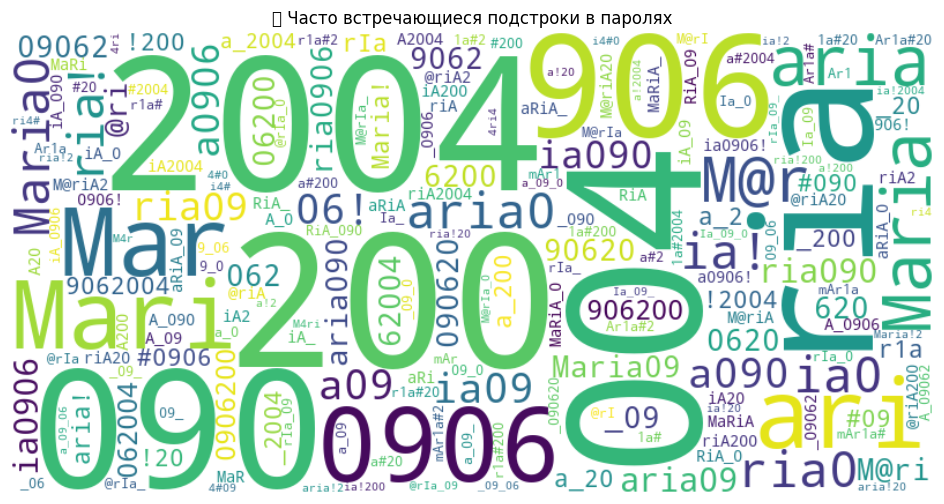

In [51]:
from wordcloud import WordCloud

word_freq = results["words"]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("🔥 Часто встречающиеся подстроки в паролях")
plt.show()

C:\Users\ggene\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


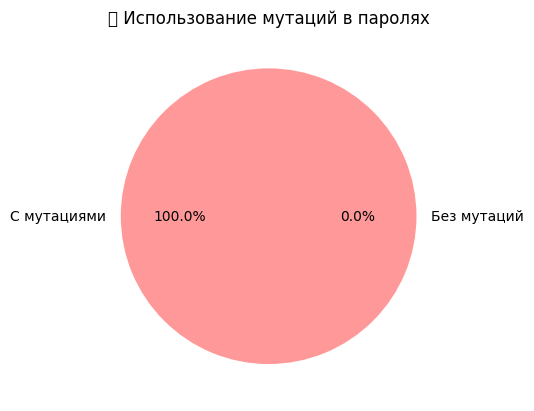

In [52]:
mutation_percent = float(results["profile"]["mutation_usage"].strip('%'))
plt.pie(
    [mutation_percent, 100 - mutation_percent],
    labels=["С мутациями", "Без мутаций"],
    autopct='%1.1f%%',
    colors=["#ff9999", "#66b3ff"]
)
plt.title("🧬 Использование мутаций в паролях")
plt.show()
